Generating fractals using Julia
    ===============================
    
    Jacek Chmiel, Director of Avenga Labs

Preparing packages and dependencies

In [37]:
using Pkg
Pkg.add("Images")
Pkg.add("ImageShow")


  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


Display image
            --

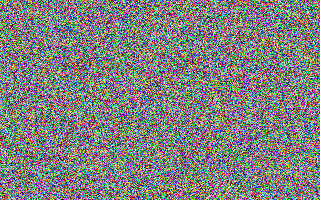

In [6]:
using Images
img = rand(RGB{Float64}, 200, 320)

You should see randomized color image above - this verifies that all dependencies are fine.

Create color palette
----

In [7]:
using Colors

my_color_palette = RGB[]
for i in 0:255 push!(my_color_palette, RGB((256-i)/255, i*6%256/255, i*2%256/255)) end


my_color_palette

In [8]:
length(my_color_palette)

256

Paint actual fractal image
    --
    

In [9]:

function fractal(start_x, start_y, scale_factor, width, height, color_palette)
    color_palette_size = length(color_palette)

    img = fill(RGB(0.0), height, width)

    # note - we use multithreaded for loop
    Threads.@threads for pixx in 1:width
        for pixy in 1:height

            # x0 = scaled x coordinate of pixel (scaled to lie in the Mandelbrot X scale (-2.5, 1))
            x0 = start_x + (pixx - 1) * scale_factor
            # y0 = scaled y coordinate of pixel (scaled to lie in the Mandelbrot Y scale (-1, 1))
            y0 = start_y + (pixy - 1) * scale_factor 

            x = 0.0
            y = 0.0
            iteration = 0
            max_iteration = 1000

            # Here N = 2^8 is chosen as a reasonable bailout radius.
            while x*x + y*y ≤ (1 << 16) && iteration < max_iteration
                xtemp = x*x - y*y + x0
                y = 2*x*y + y0
                x = xtemp
                iteration = iteration + 1
            end

            # Used to avoid floating point issues with points inside the set.
            if iteration < max_iteration 
                # sqrt of inner term removed using log simplification rules.
                log_zn = log(x*x + y*y) / 2
                nu = log(log_zn / log(2)) / log(2)
                # Rearranging the potential function.
                # Dividing log_zn by log(2) instead of log(N = 1<<8)
                # because we want the entire palette to range from the
                # center to radius 2, NOT our bailout radius.
                iteration = iteration + 1 - nu
            end

            color_index = 1 + floor(Int, iteration) % color_palette_size

            # paint the actual image
            img[pixy, pixx] = color_palette[color_index]

        end
    end

    return img
end

    

fractal (generic function with 1 method)

Some examples of beatiful fractals
--


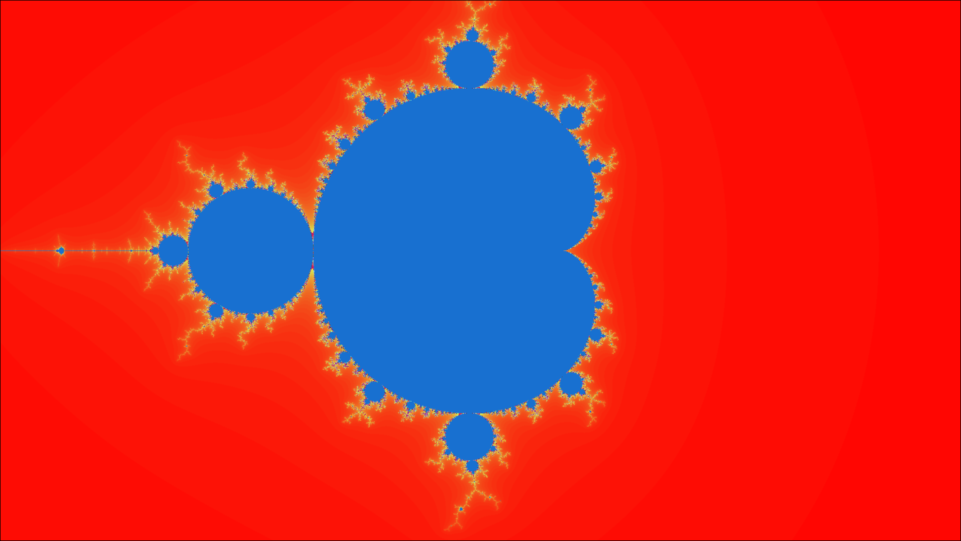

In [10]:
fractal(-2.0, -1, 0.002, 1920, 1080, my_color_palette)

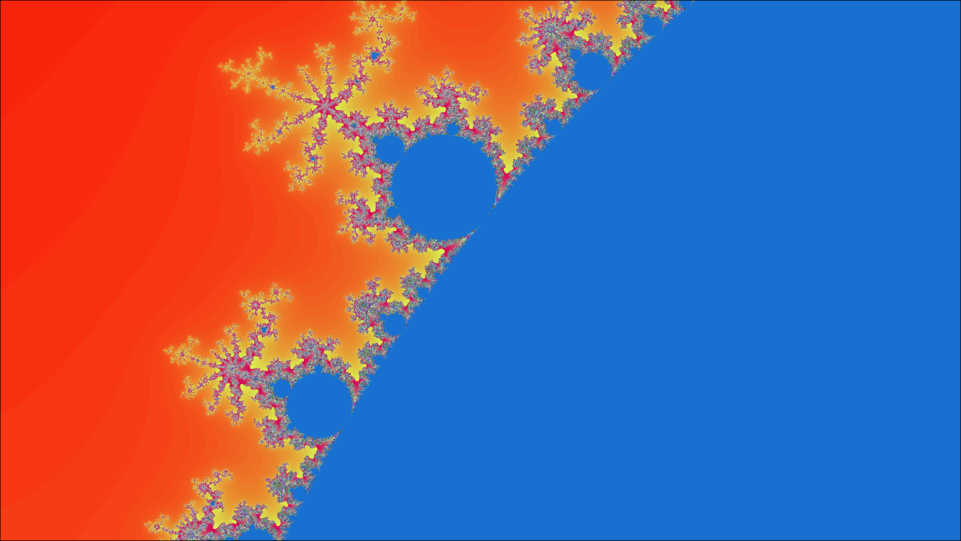

In [11]:
fractal(-0.8, -0.5, 0.0002, 1920, 1080, my_color_palette)

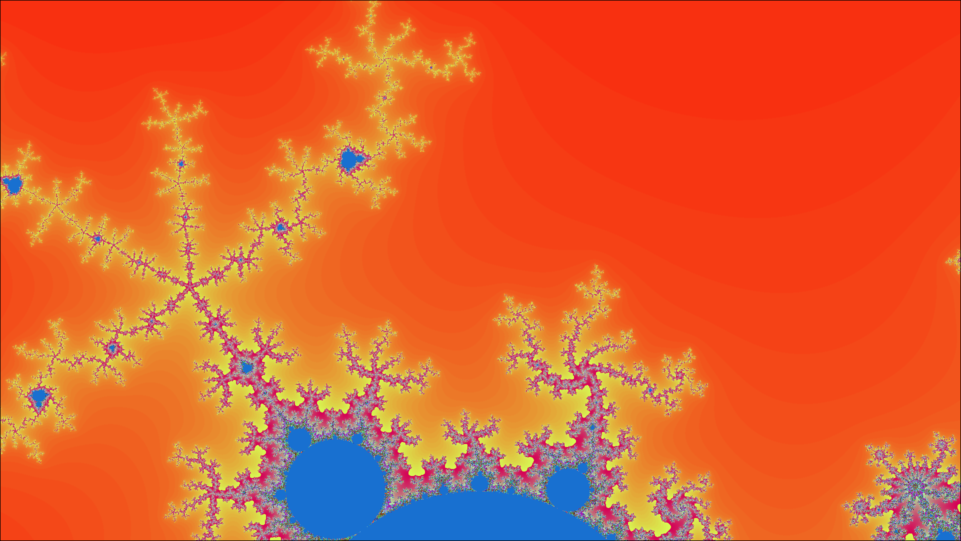

In [12]:
fractal(-0.6, -0.7, 0.0001, 1920, 1080, my_color_palette)

Multithreading vs. single thread
---
Let's create single threaded version of fractal called **single_thread_fractal** and then compare the performance

In [13]:
function single_thread_fractal(start_x, start_y, scale_factor, width, height, color_palette)
    color_palette_size = length(color_palette)

    img = fill(RGB(0.0), height, width)

    for pixx in 1:width
        for pixy in 1:height

            # x0 = scaled x coordinate of pixel (scaled to lie in the Mandelbrot X scale (-2.5, 1))
            x0 = start_x + (pixx - 1) * scale_factor
            # y0 = scaled y coordinate of pixel (scaled to lie in the Mandelbrot Y scale (-1, 1))
            y0 = start_y + (pixy - 1) * scale_factor 

            x = 0.0
            y = 0.0
            iteration = 0
            max_iteration = 1000

            # Here N = 2^8 is chosen as a reasonable bailout radius.
            while x*x + y*y ≤ (1 << 16) && iteration < max_iteration
                xtemp = x*x - y*y + x0
                y = 2*x*y + y0
                x = xtemp
                iteration = iteration + 1
            end

            # Used to avoid floating point issues with points inside the set.
            if iteration < max_iteration 
                # sqrt of inner term removed using log simplification rules.
                log_zn = log(x*x + y*y) / 2
                nu = log(log_zn / log(2)) / log(2)
                # Rearranging the potential function.
                # Dividing log_zn by log(2) instead of log(N = 1<<8)
                # because we want the entire palette to range from the
                # center to radius 2, NOT our bailout radius.
                iteration = iteration + 1 - nu
            end

            color_index = 1 + floor(Int, iteration) % color_palette_size

            # paint the actual image
            img[pixy, pixx] = color_palette[color_index]

        end
    end

    return img
end



single_thread_fractal (generic function with 1 method)

Now let's compare the performance of multi-threaded fractal function with single threaded fractal function. Note how convenient it is to measure time of execution with **@time** macro.

Multithreaded, number of threads = 12
  1.989718 seconds (245 allocations: 189.863 MiB, 0.20% gc time)
 14.157791 seconds (108.11 k allocations: 195.988 MiB, 0.02% gc time)


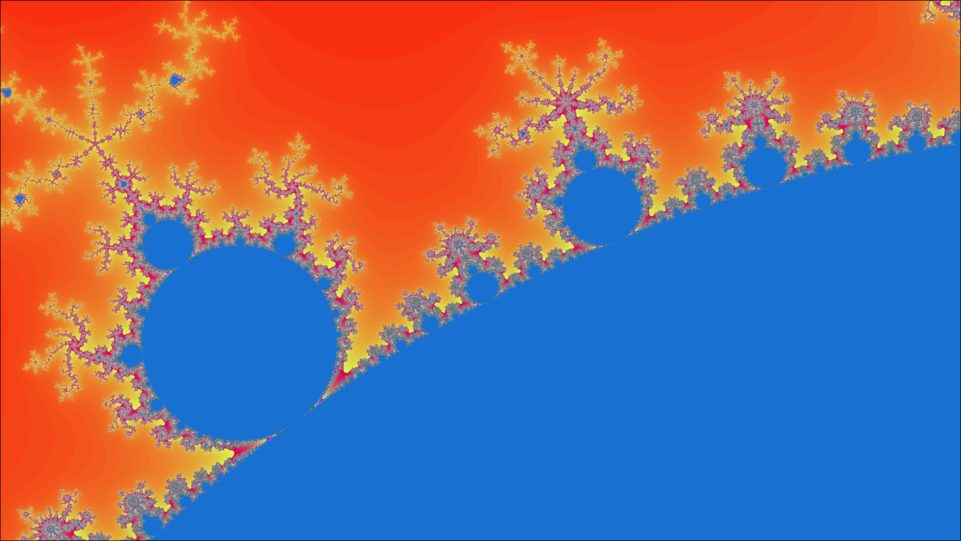

In [14]:
println("Multithreaded, number of threads = ", Threads.nthreads())

@time img = fractal(-0.6, -0.7, 0.0001, 3840, 2160, my_color_palette)

@time img = single_thread_fractal(-0.6, -0.7, 0.0001, 3840, 2160, my_color_palette)

img


In [31]:
using Colors 

dark_color_palette = RGB[]
for i in 0:256 push!(dark_color_palette, RGB((i/4)/255, i%256/255, i*3%256/255)) end

dark_color_palette

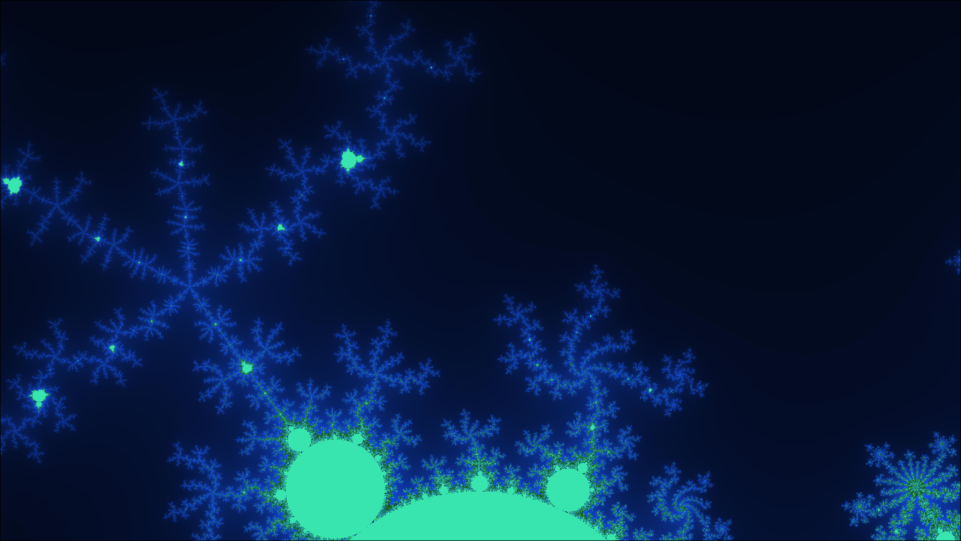

In [32]:
fractal(-0.6, -0.7, 0.0001, 1920, 1080, dark_color_palette)

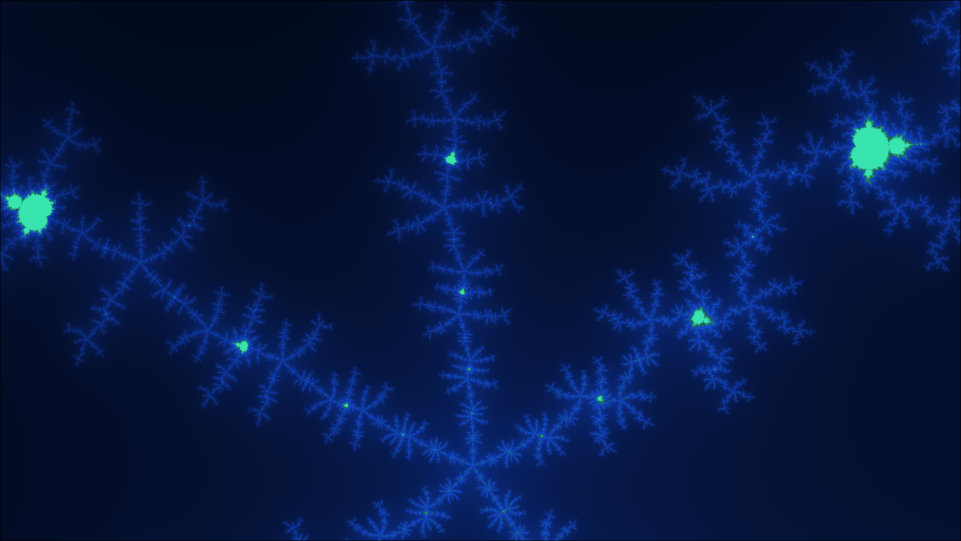

In [33]:
fractal(-0.6+0.00004, -0.7+0.02, 0.00004, 1920, 1080, dark_color_palette)